# Final Project

## Names: SOPHIA, CAM

- Insert Markdown chunks for your written responses as needed
- Do not include unnecessary code. Only code that is needed to answer the questions should be included, nothing more. 
- Be sure your work is **reproducible** by "Restart and Clear Output" then "Run All" cells
- The group leader will make a single submission on Moodle on behalf of the group. 
- **ACKNOWELDGE ALL EXTERNAL SOURCES HERE:** Give a brief summary of any external sources you used. Ex:
    - https://pankaj8blr.medium.com/eda-and-significance-of-various-plots-in-feature-engineering-f8cededbd520
    - https://seaborn.pydata.org/generated/seaborn.kdeplot.html
    - Google AI overview for XXX
    - StackOverflow for YYY

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
from spellchecker import SpellChecker
import seaborn as sns
import warnings   # We will turn of the future warnings that xgboost gives us
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb
from sklearn.model_selection import GridSearchCV



## 1. The Data

The dataset we chose is [LLM - Detect AI Generated Text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview) where:

* Outcome variable: Binary, AI generated (1) or human generated (0)
* Predictor variables: -- all created through feature engineering of essay text
* Number of observations:
    * Training set: $n_{train} = 27770$
    * Test set: $n_{test} = 9000$
* Score/metric used for the [leaderboard](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/leaderboard): Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [65]:
# Load all datasets here. 
train = pd.read_csv("data/train_essays_complete.csv", sep=',', index_col = 'essay_id')
# Kaggle really should've named this field sex_submission.csv
#example_submission = pd.read_csv("data/gender_submission.csv", sep=',', index_col = 'PassengerId')

# Note we set the PassengerId identification variable as the index of each 
# row by setting index_col = 'PassengerId'. That way PassengerId isn't an
# an actual column of data, but rather metadata about each row.
train.head()

## Train/test split
train_essay, test_essay = train_test_split(train, test_size=0.3, random_state=38)

## Separate outcome
train_essay_y = train_essay['generated']
train_essay_X = train_essay['text']
test_essay_y = test_essay['generated']
test_essay_X = test_essay['text']



## 2. Exploratory Data Analysis

Perform all necessary EDA here. Before submitting, only keep those you feel are relevant

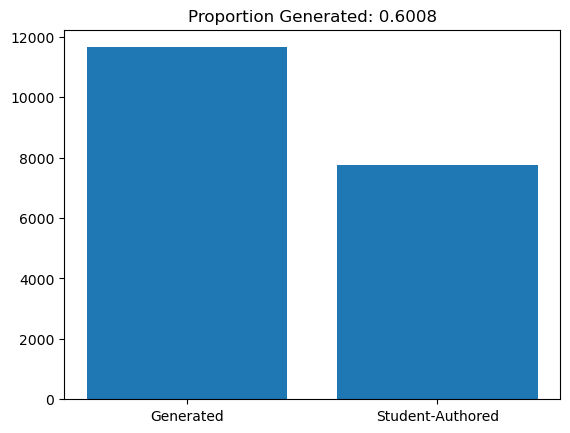

In [66]:
# Univariate visualization of outcome variable:
y_train_cat = train_essay_y.map({1: 'Generated', 0: 'Student-Authored'})
category_counts = pd.Series(y_train_cat).value_counts()
plt.bar(x = category_counts.index, height = category_counts.values)
prop_gen = train_essay_y.mean()
plt.title("Proportion Generated: " + str(f"{prop_gen:.4f}"))
plt.show()

## 3. Feature Engineering

Perform your feature engineering here and then create `y_train`, `X_train` and `X_test`. 

In [67]:
train_essay["text"] = train_essay["text"].str.lower()

In [68]:
# Define inputs for variables 

input_transition = ["first", "firstly", "second", "secondly", "third", "thirdly", "meanwhile", "previously", "subsequently", "eventually", 
                    "finally", "lastly", "ultimately", "conclusion", "addition", "additionally", "furthermore", "moreover", "besides", 
                    "equally", "however", "contrary", "conversely", "despite", "contrast", "nevertheless", "nonetheless", "whereas", "while",
                    "although", "though", "therefore", "thus", "hence", "consequently", "accordingly", "namely", "specifically", "indeed", 
                    "importantly", "significantly", "especially", "notably", "undoubtedly", "likewise", "similarly", "correspondingly", "sum",
                    "summary", "overall", "conclude", "conclusion", "simultaneously", "formerly", "lately", "recently", "opposite", "adjacent",
                    "provided", "admittedly", "regarding"]

input_hyperbole = ["powerful", "groundbreaking", "illuminating", "vital", "invaluable", "indelible", "essential", "poignant", "profound", 
                   "remarkable", "transformative", "revolutionary", "unparalleled", "extraordinary", "compelling", "significant", "exceptional",
                   "crucial", "monumental", "dramatic", "robust", "innovative", "pivotal", "impressive", "astonishing", "visionary", "inspiring",
                   "striking", "dynamic", "iconic", "seminal", "trailblazing", "revolutionary", "extreme", "shocking"]

input_abn_symbols = ["[", "]", "_", "*", "<", ">", "{", "}", "^", "@", "#", "|", "\\"]

input_prompt_lang = ["here you go", "as an ai", "as a language model", "i generated", "here's the essay", "here's your essay", "let me", 
                     "help you", "sure,", "i hope this helps", "your prompt", "your request", "here is", "here's", "sure!", 
                     "here is the essay", "here is your essay", "language model", "large language", "llm", "generative ai", "chatbot", 
                     "your essay"]

In [69]:
# Create new variables 

### Spelling errors
spell = SpellChecker()

def clean_text_for_spellcheck(text):
    if pd.isna(text):
        return ""
    for symbol in input_abn_symbols:
        text = text.replace(symbol, "")
    text = re.sub(r"[^a-z\s'-]", "", text.lower())
    return text

def misspelling_ratio(text):
    text_clean = clean_text_for_spellcheck(text)
    words = text_clean.split()
    if len(words) == 0:
        return 0.0 
    misspelled = spell.unknown(words)
    return len(misspelled) / len(words)

def count_misspellings(text):
    text_clean = clean_text_for_spellcheck(text)
    words = text_clean.split()
    if len(words) == 0:
        return 0
    misspelled = spell.unknown(words)
    return len(misspelled)


train_essay["text_modified"] = train_essay["text"].apply(clean_text_for_spellcheck)
train_essay["misspelling_ratio"] = train_essay["text_modified"].apply(misspelling_ratio)
train_essay["n_misspellings"] = train_essay["text_modified"].apply(count_misspellings)

### Exclamation points
def count_exclamation_points(text):
    return text.count('!')
train_essay["n_exclamations"] = train_essay["text"].apply(count_exclamation_points)


### Em dashes
def count_em_dash(text):
    return text.count('—')
train_essay["n_em_dash"] = train_essay["text"].apply(count_em_dash)


### Transitional words
def count_transition(text):
    return sum(text.count(word) for word in input_transition)
train_essay["n_transition_words"] = train_essay["text"].apply(count_transition)


### Hyperbolic phrasing
def count_hyperbolic(text):
    return sum(text.count(word) for word in input_hyperbole)
train_essay["n_hyperbolic"] = train_essay["text"].apply(count_hyperbolic)


### Abnormal symbols
def count_abn_symbols(text):
    return sum(text.count(word) for word in input_abn_symbols)
train_essay["n_abn_symbols"] = train_essay["text"].apply(count_abn_symbols)


## Prompt indicator
def contains_prompt_indicators(text):
    return int(any(indicator in text for indicator in input_prompt_lang))
train_essay["prompt_indicator"] = train_essay["text"].apply(contains_prompt_indicators)

## EDA for Feature Engineering

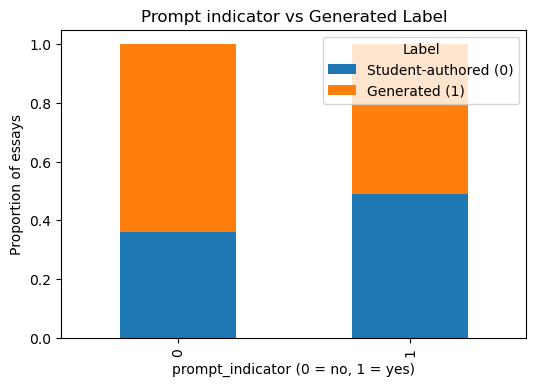

In [70]:
df = train_essay

# Crosstab
pd.crosstab(df['prompt_indicator'], df['generated'])

# Stacked bar plot
crosstab = pd.crosstab(
    df['prompt_indicator'],
    df['generated'],
    normalize='index'
)

crosstab.plot(kind='bar', stacked=True, figsize=(6,4))
plt.xlabel('prompt_indicator (0 = no, 1 = yes)')
plt.ylabel('Proportion of essays')
plt.legend(['Student-authored (0)', 'Generated (1)'], title='Label')
plt.title('Prompt indicator vs Generated Label')
plt.show()

In [71]:
#splitting up features for analysis, count_features are numeric, ratio_feature is proportion. 
#they should be visualized differently

count_features = [
    'n_misspellings',
    'n_exclamations',
    'n_em_dash',
    'n_abn_symbols',
    'n_transition_words',
    'n_hyperbolic'
]

ratio_features = ['misspelling_ratio']

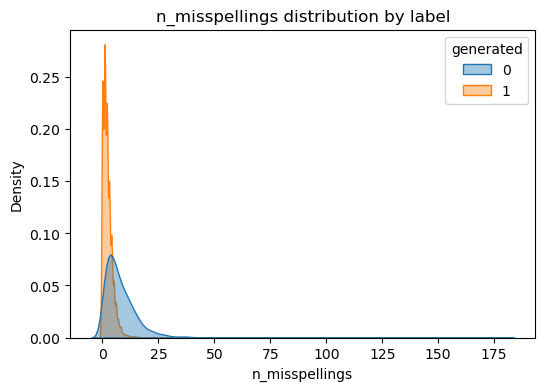

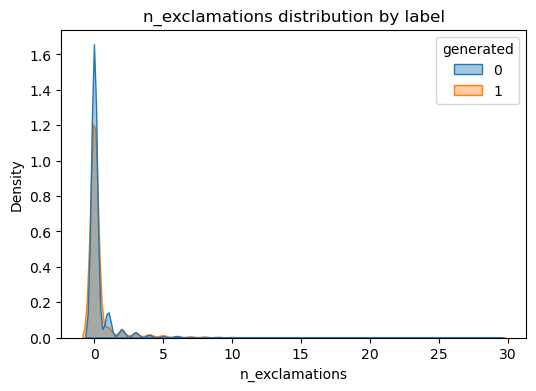

/var/folders/pp/vt7flv394s93wbs837r758yc0000gq/T/ipykernel_84651/2067240690.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


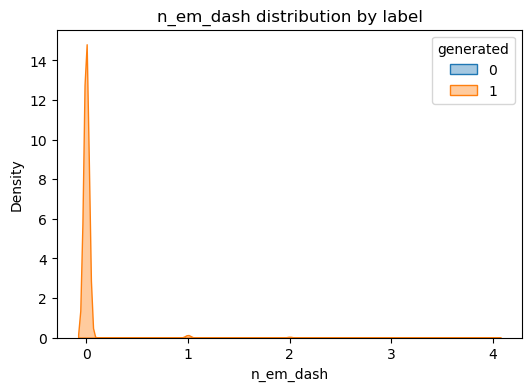

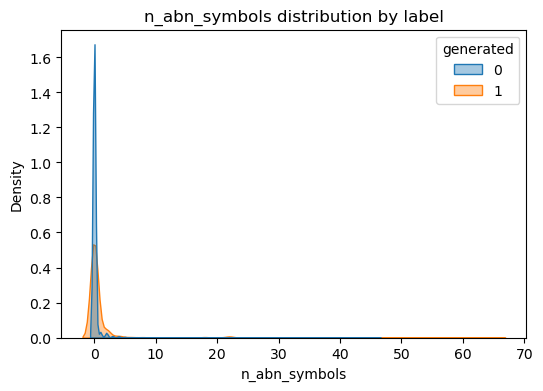

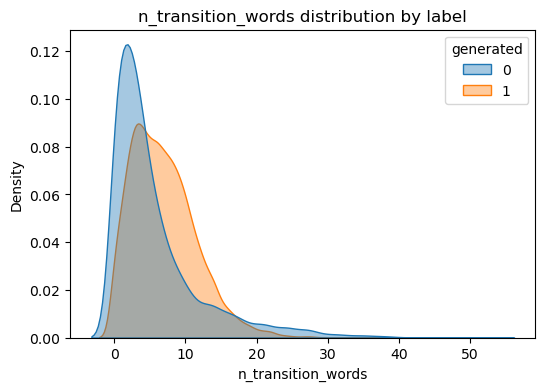

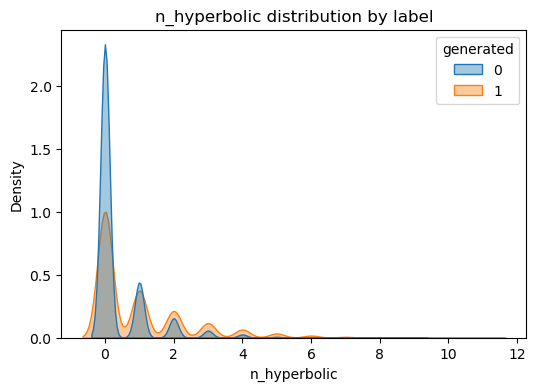

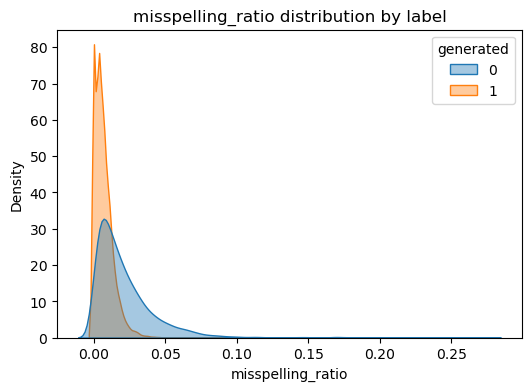

In [72]:
for col in count_features + ratio_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(
        data=df,
        x=col,
        hue='generated',
        common_norm=False,
        fill=True,
        alpha=0.4
    )
    plt.title(f'{col} distribution by label')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

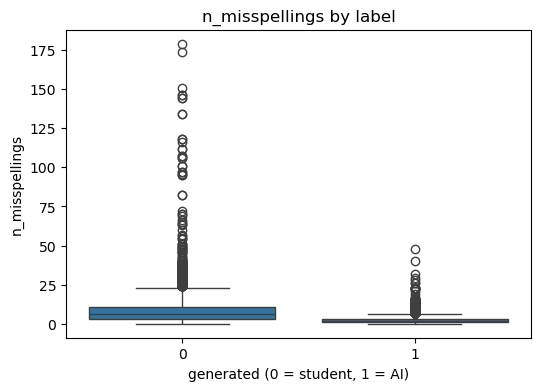

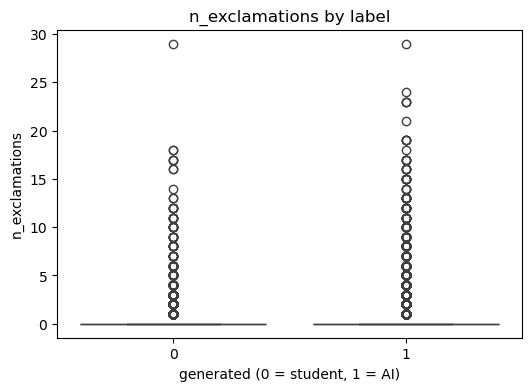

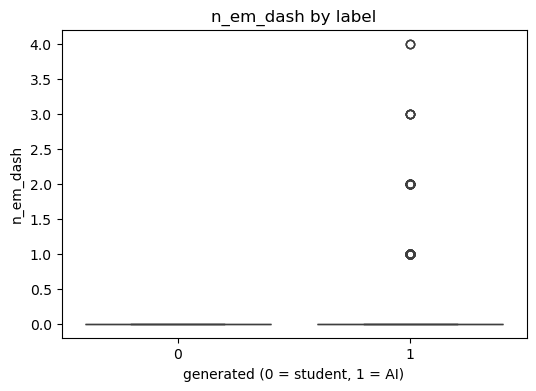

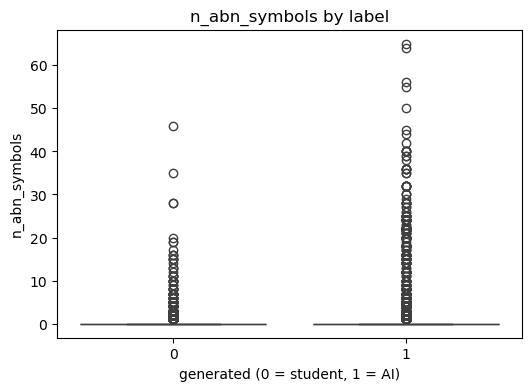

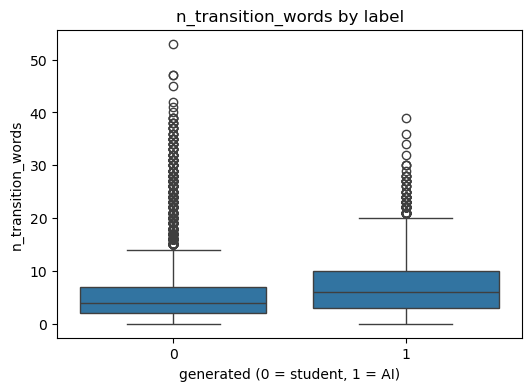

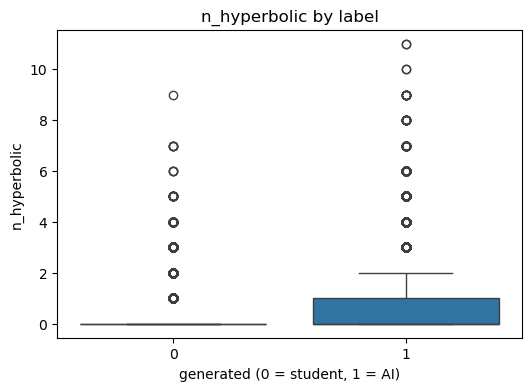

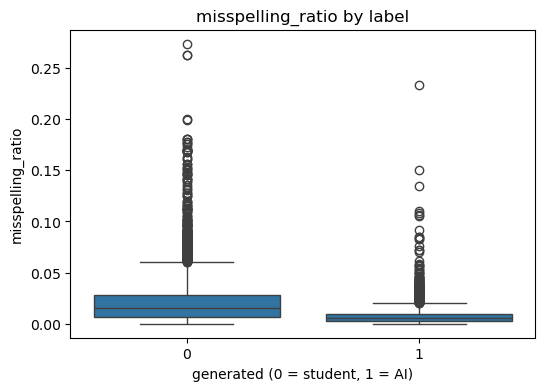

In [74]:
for col in count_features + ratio_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='generated', y=col)
    plt.title(f'{col} by label')
    plt.xlabel('generated (0 = student, 1 = AI)')
    plt.show()

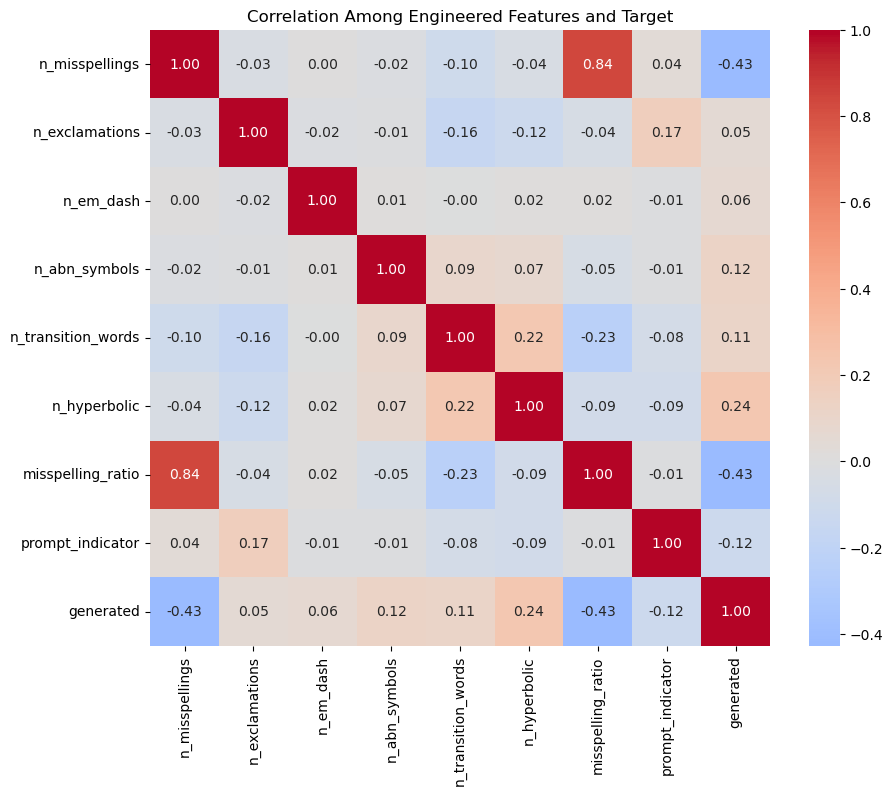

In [75]:
feature_cols = count_features + ratio_features + ['prompt_indicator']

corr = df[feature_cols + ['generated']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Among Engineered Features and Target')
plt.show()

#### Splitting with new features

In [76]:
feature_cols = [
    'prompt_indicator',
    'n_misspellings',
    'n_exclamations',
    'n_em_dash',
    'n_abn_symbols',
    'n_transition_words',
    'n_hyperbolic',
    'misspelling_ratio'
    # add any other numeric features you created
]

X = train_essay[feature_cols]
y = train_essay['generated']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=38, stratify=y
)

## 4. Data preparation pipelines and pre-processing

Run all preparation and pre-processing pipelines here

In [82]:
## Example pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=38)),
    ('model', xgb.XGBClassifier(eval_metric="auc"))
])


parms = {'model__learning_rate': [0.01, 0.05, 0.07, 0.1, 0.12, 0.15, 0.18, 0.21, 0.3],
        'pca__n_components': [3,5,6, None]}

## Grid Search
grid_res = GridSearchCV(
    estimator = pipe, 
    param_grid = parms, 
    cv=5).fit(X_train, y_train)

## Print results
print(grid_res.best_params_)
print(grid_res.best_score_)

{'model__learning_rate': 0.15, 'pca__n_components': None}
0.8812453288169992


## 5. Model selection and hyperparameter tuning

Perform all model selection and hyperpareter tuning here. Create separate pipelines here

## 6. Creation of final pipeline

Create your final pipeline here and save it in an object called `pipe_final`. 

## 7. Creating Submission

* Using `pipe_final`, create a data frame `final_submission` that has your predictions and write to `final_submission.csv` that you can submit on Kaggle. Note the format of `final_submission.csv` has to match that `example_submission.csv` exactly.
* Take a screen shot of your final leaderboard score and ensure it displays below
* Run the `RepeatedKFold()` as you did in PS3. 


* Keep track of at least one score a day

In [ ]:
# Apply pipe_final to create final_submission data frame here:


# Write to CSV. Note setting index=True will output the row indices `PassengerId`
# as the first column of the CSV
final_submission.to_csv('data/final_submission.csv', index=True)

In [ ]:
from IPython.display import Image
Image("images/leaderboard.png")

In [ ]:
cv_final = RepeatedKFold(n_splits=5, n_repeats=10, random_state=38)
scores_final = cross_val_score(pipe_final, X_train, y_train, scoring='accuracy', cv=cv_final)
print(f'Mean accuracy: {np.mean(scores_final):.3f}')

## 8. Appendix

Please anything extra that you don't feel is central, but would still like to keep here